# Simulation and parameter recovery of dynamic foraging task.

In [ ]:
pip install -e /root/capsule

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask, UncoupledBlockTask
from aind_dynamic_foraging_models.generative_model import ForagerCollection

## Get all foragers

In [2]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [3]:
df[["agent_class_name", "preset_name", "n_free_params", "params"]]

,agent_class_name,preset_name,n_free_params,params
0,ForagerQLearning,None,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
1,ForagerQLearning,Rescorla-Wagner,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
2,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
3,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
4,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
5,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
6,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
7,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
8,ForagerQLearning,Bari2019,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
9,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."


## Initialize an agent

In [4]:
# Initialize the model
forager_gen = ForagerCollection().get_preset_forager("CompareToThreshold", seed=42)
forager_gen.set_params(
    threshold=0.1,
    learn_rate=0.5,
    softmax_inverse_temperature=5,
    biasL=0,
)
# forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
# forager.set_params(
#     softmax_inverse_temperature=5,
#     biasL=0,
# )

# Create the task environment
# task = CoupledBlockTask(reward_baiting=True, num_trials=500, seed=42)
task = UncoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42)

## Simulation the task

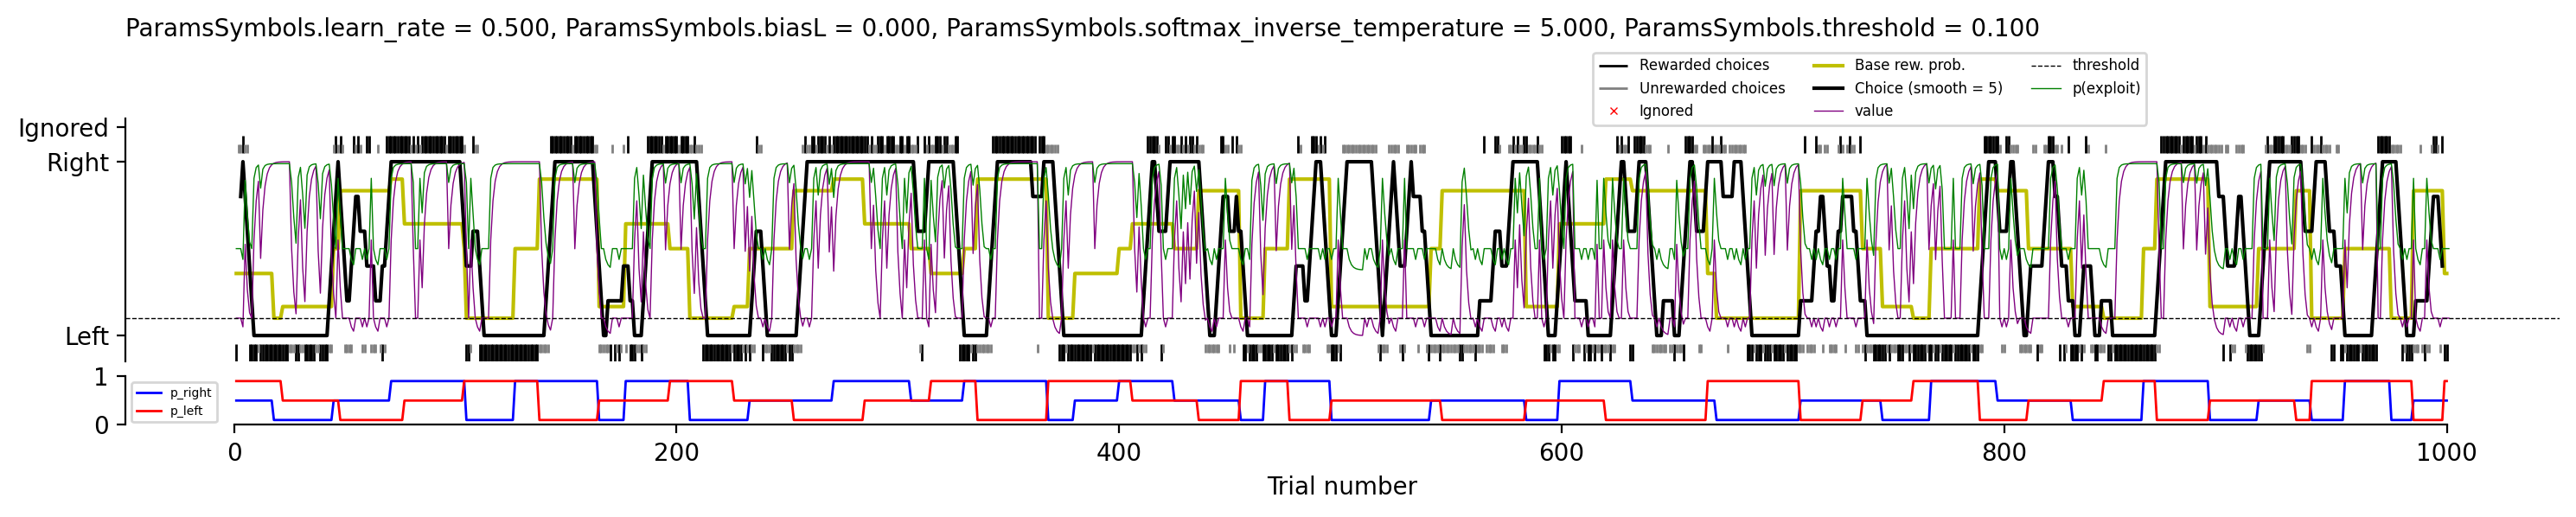

In [5]:
# Run the model
forager_gen.perform(task)

# Capture the results
ground_truth_params = forager_gen.params.model_dump()
ground_truth_choice_prob = forager_gen.choice_prob
ground_truth_value = forager_gen.value
# Get the history
choice_history = forager_gen.get_choice_history()
reward_history = forager_gen.get_reward_history()

# Plot the session results
fig, axes = forager_gen.plot_session(if_plot_latent=True)

## Parameter Recovery

In [15]:
# Fit the model to recover parameters
# forager_fit = ForagerCollection().get_preset_forager("CompareToThreshold", seed=42)
forager_fit = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager_fit.fit(
    choice_history,
    reward_history,
    # fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
    clamp_params={
        "biasL": 0, 
        # "softmax_inverse_temperature": 5.0
    },
    DE_kwargs=dict(
        workers=4, 
        disp=True, 
        seed=np.random.default_rng(42)
    ),
    k_fold_cross_validation=None,
)

fitting_result = forager_fit.fitting_result

2025-04-23 23:55:42,079 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 352.1914351253272
differential_evolution step 2: f(x)= 352.1914351253272
differential_evolution step 3: f(x)= 352.1914351253272
differential_evolution step 4: f(x)= 342.362022268278
differential_evolution step 5: f(x)= 336.54306978741715
differential_evolution step 6: f(x)= 336.54306978741715
differential_evolution step 7: f(x)= 336.54306978741715
differential_evolution step 8: f(x)= 336.54306978741715
differential_evolution step 9: f(x)= 336.54306978741715
differential_evolution step 10: f(x)= 336.54306978741715
differential_evolution step 11: f(x)= 336.54306978741715
differential_evolution step 12: f(x)= 336.40488494674685
differential_evolution step 13: f(x)= 335.2308049666704
differential_evolution step 14: f(x)= 335.2308049666704
differential_evolution step 15: f(x)= 334.7421218311729
differential_evolution step 16: f(x)= 334.4050971030038
differential_evolution step 17: f(x)= 333.4592773202058
differential_evolution step 18: f(x)= 333.45927732

In [16]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['5.0000']
Fitted:       ['0.3949', '0.3952', '1.0000', '4.6847']
Likelihood-Per-Trial: 0.716694751641006
Prediction accuracy full dataset: 0.837



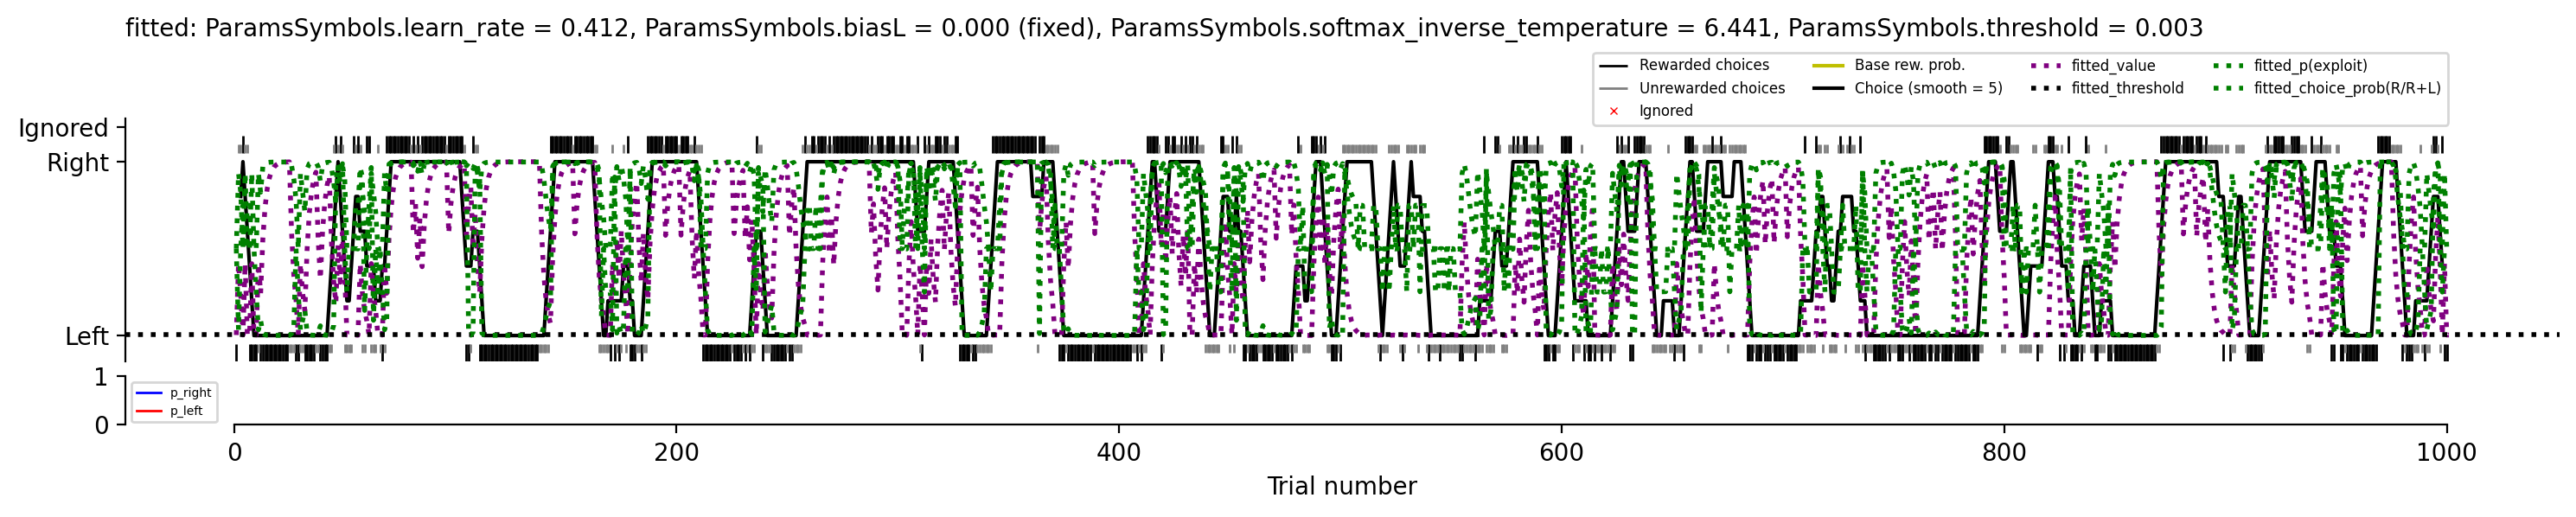

In [14]:
# Plot the fitted session results
fig_fitting, axes = forager_fit.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
# axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
# axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
# axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)